# 跨国在线零售业务的交易数据
```
字段名称 类型 含义 举例
InvoiceNo string 订单编号（退货订单以C开头） 536365
StockCode string 产品代码 85123A
Description string 产品描述 WHITE METAL LANTERN
Quantity integer 购买数量（负数表示退货） 6
InvoiceDate string 订单日期和时间 12/1/2010 8:26
UnitPrice double 单价（英镑） 3.39
CustomerID integer 客户编号 17850
Country string 国家名称 United Kingdom
```
上传hadfs
```
hdfs dfs -put data.csv
```

In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

spark = SparkSession.builder.config(conf=SparkConf()).getOrCreate()

In [2]:
spark

## 数据预处理

In [3]:
df = spark \
    .read \
    .format("com.databricks.spark.csv")\
    .options(header='true', inferschema='true') \
    .load("data.csv")

In [4]:
df.count()  # 不包含标题行

541909

In [5]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [6]:
# 创建零时表
df.createOrReplaceTempView('data')

In [7]:
# 由于顾客编号CustomID和商品描述Description均存在部分缺失，所以进行数据清洗，过滤掉有缺失值的记录
# 由于CustomID为integer类型，所以该字段若为空，则在读取时被解析为0，故用df[“CustomerID”]!=0 条件过滤
cleaned_data = df.filter(df['CustomerID']!=0).filter(df['Description']!='')
cleaned_data.count()

406829

In [9]:
# 清洗后的数据写入csv
cleaned_data \
    .write \
    .format("com.databricks.spark.csv") \
    .options(header='true', inferschema='true') \
    .save("Cleaned_data.csv")

## 数据分析

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.figsize'] = [8, 6]
# ['Noto Sans CJK JP']  SimHei
plt.rcParams['font.family'] = ['Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus'] = False

In [12]:
def save(path, data):
    with open(path, 'w') as f:
        f.write()

In [4]:
df = spark \
    .read \
    .format("com.databricks.spark.csv")\
    .options(header='true', inferschema='true') \
    .load("Cleaned_data.csv")

In [5]:
df.createOrReplaceTempView("data")

### 分析客户最多的10个国家


In [15]:
    SELECT
        country,  COUNT(DISTINCT CustomerID) as Customer_SUM
    FROM
        data
    GROUP BY
        country
    ORDER BY
        Customer_SUM DESC
    LIMIT 10
""")
country_customer.show()

+--------------+------------+
|       country|Customer_SUM|
+--------------+------------+
|United Kingdom|        3950|
|       Germany|          95|
|        France|          87|
|         Spain|          31|
|       Belgium|          25|
|   Switzerland|          21|
|      Portugal|          19|
|         Italy|          15|
|       Finland|          12|
|       Austria|          11|
+--------------+------------+



In [24]:
pdf = country_customer.toPandas()

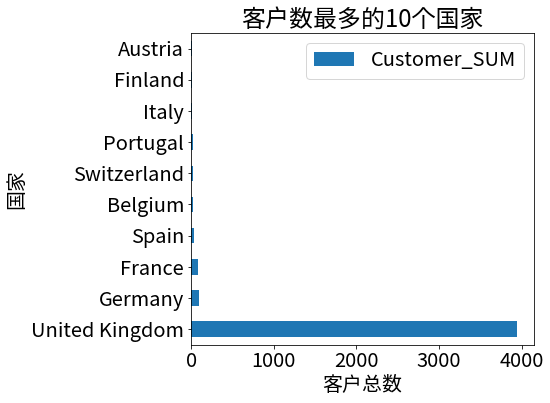

In [32]:
pdf.plot.barh(y='Customer_SUM', x="country")
plt.xlabel("客户总数")
plt.ylabel('国家')
plt.title("客户数最多的10个国家")
plt.tight_layout()
plt.show()

In [17]:
cc_list = country_customer.collect()
cc_list

[Row(country='United Kingdom', Customer_SUM=3950),
 Row(country='Germany', Customer_SUM=95),
 Row(country='France', Customer_SUM=87),
 Row(country='Spain', Customer_SUM=31),
 Row(country='Belgium', Customer_SUM=25),
 Row(country='Switzerland', Customer_SUM=21),
 Row(country='Portugal', Customer_SUM=19),
 Row(country='Italy', Customer_SUM=15),
 Row(country='Finland', Customer_SUM=12),
 Row(country='Austria', Customer_SUM=11)]

### 销量最高的10个国家

In [28]:
countryQuantity = spark.sql("""
    SELECT 
        country, SUM(Quantity) as Quantity_SUM
    FROM
        data
    GROUP BY
        country
    ORDER BY
        Quantity_SUM DESC
    LIMIT
         10
""")

In [29]:
countryQuantity.show()

+--------------+------------+
|       country|Quantity_SUM|
+--------------+------------+
|United Kingdom|     4008533|
|   Netherlands|      200128|
|          EIRE|      136329|
|       Germany|      117448|
|        France|      109848|
|     Australia|       83653|
|        Sweden|       35637|
|   Switzerland|       29778|
|         Spain|       26824|
|         Japan|       25218|
+--------------+------------+



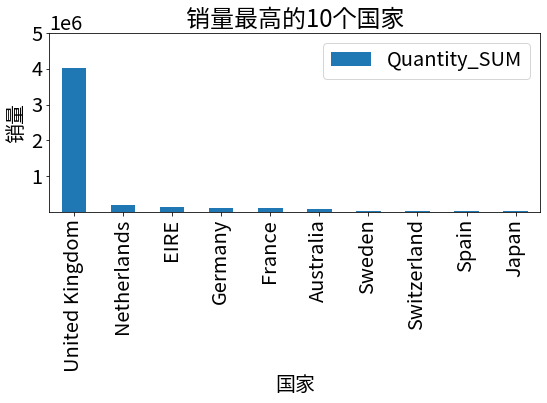

In [38]:
pdf = countryQuantity.toPandas()
pdf.plot.bar(x='country', y='Quantity_SUM')
plt.xlabel("国家")
plt.ylabel("销量")
plt.title("销量最高的10个国家")
plt.tight_layout()
plt.yticks([1000000,2000000,3000000, 4000000, 5000000])
plt.show()

### 各个国家的总销售额分布情况

UnitPrice 字段表示单价，Quantity字段表示销量

In [41]:
countrySumOfPriceDF = spark.sql("""
    SELECT
        country, SUM(UnitPrice * Quantity) as sum_price
    FROM
        data
    GROUP BY
        country
""")
countrySumOfPriceDF.show()

+------------------+------------------+
|           country|         sum_price|
+------------------+------------------+
|            Sweden| 36595.90999999999|
|         Singapore| 9120.390000000001|
|           Germany|221698.21000000063|
|               RSA|1002.3099999999998|
|            France|196712.84000000005|
|            Greece|           4710.52|
|European Community|           1291.75|
|           Belgium| 40910.95999999999|
|           Finland|22326.739999999998|
|             Malta|2505.4700000000007|
|       Unspecified|2667.0699999999997|
|             Italy|16890.509999999995|
|              EIRE|250285.21999999968|
|         Lithuania|           1661.06|
|            Norway| 35163.45999999999|
|             Spain| 54774.58000000003|
|           Denmark|          18768.14|
|            Israel| 6994.250000000001|
|           Iceland|            4310.0|
|   Channel Islands|          20086.29|
+------------------+------------------+
only showing top 20 rows



### 销量最高的10个商品


In [43]:
stockQuantityDF = spark.sql("""
    SELECT
        StockCode, SUM(Quantity) as total_Quantity
    FROM
        data
    GROUP BY
        StockCode
    ORDER BY
        total_Quantity DESC
    LIMIT
        10
""")
stockQuantityDF.show()

+---------+--------------+
|StockCode|total_Quantity|
+---------+--------------+
|    84077|         53215|
|    22197|         48712|
|   85099B|         45066|
|    84879|         35314|
|   85123A|         34204|
|    21212|         33409|
|    23084|         27094|
|    22492|         25880|
|    22616|         25321|
|    21977|         24163|
+---------+--------------+



### 商品描述的热门关键词Top300

In [36]:
from pyspark.sql.functions import lower
from pyspark.sql.types import *

In [48]:
# 1
desc = df.select(lower(df['Description']).alias('Description'))
desc.show()

+--------------------+
|         Description|
+--------------------+
|    jumbo bag apples|
|jumbo bag vintage...|
|doorstop retrospo...|
|pink cream felt c...|
|feltcraft butterf...|
|vintage union jac...|
|       party bunting|
|colouring pencils...|
|hanging heart jar...|
| lunch bag cars blue|
|lunch bag red ret...|
|lunch bag  black ...|
|lunch bag suki de...|
|lunch bag pink po...|
|lunch bag apple d...|
|lunch bag vintage...|
|lunch bag vintage...|
|ice cream pen lip...|
|magic drawing sla...|
|magic drawing sla...|
+--------------------+
only showing top 20 rows



In [49]:
# 2
desc = spark.sql("select lower(Description) as Description from data")
desc.show(2)

+--------------------+
|         Description|
+--------------------+
|    jumbo bag apples|
|jumbo bag vintage...|
+--------------------+
only showing top 2 rows



In [53]:
desc.rdd.take(1)

[Row(Description='jumbo bag apples')]

In [51]:
top_words = desc \
        .rdd \
        .flatMap(lambda x: x["Description"].split(" ")) \
        .map(lambda word: (word, 1)) \
        .reduceByKey(lambda x1, x2: x1+x2) \
        .repartition(1) \
        .sortBy(lambda x: x[1], ascending=False)

In [56]:
top_words.take(5)

[('set', 41623),
 ('of', 41479),
 ('bag', 38452),
 ('red', 32590),
 ('heart', 29443)]

In [64]:
schema = StructType([
    StructField('word', StringType(), False),
    StructField('count', IntegerType(), False)
])

words_df = spark.createDataFrame(top_words, schema)

In [67]:
top_words_df = words_df.filter(words_df['word'] !='').take(300)
top_words_df[:2]

[Row(word='set', count=41623), Row(word='of', count=41479)]

## 退货订单数最多的10个国家

InvoiceNo字段表示订单编号，所以订单总数为COUNT(DISTINCT InvoiceNo)，由于退货订单的编号的首个字母为C，例如C540250

In [72]:
country_Invoice = spark.sql("""
    SELECT
        country, COUNT(DISTINCT InvoiceNo) as country_invoice
    FROM
        data
    WHERE
        InvoiceNo LIKE "C%"
    GROUP BY
        country
    ORDER BY
        country_invoice DESC
    LIMIT
        10
""")

In [73]:
country_Invoice.show()

+--------------+---------------+
|       country|country_invoice|
+--------------+---------------+
|United Kingdom|           3208|
|       Germany|            146|
|        France|             69|
|          EIRE|             59|
|       Belgium|             21|
|   Switzerland|             20|
|         Italy|             17|
|         Spain|             15|
|      Portugal|             13|
|     Australia|             12|
+--------------+---------------+



### 月销售额随时间的变化趋势

统计月销售额需要3个字段的信息，分别为订单日期InvoiceDate，销量Quantity和单价UnitPrice

In [40]:
df1 = spark.createDataFrame([('1997-2-1',)], ['t'])
df1.select(to_date(df1.t).alias('date')).collect()

[Row(date=datetime.date(1997, 2, 1))]

In [103]:
df.select('InvoiceDate', "Quantity", 'UnitPrice').show(10)  # 月 日 年

+---------------+--------+---------+
|    InvoiceDate|Quantity|UnitPrice|
+---------------+--------+---------+
|8/11/2011 10:45|      10|     2.08|
|8/11/2011 10:45|      10|     2.08|
|8/11/2011 10:45|       4|     3.75|
|8/11/2011 10:45|      12|     1.25|
|8/11/2011 10:45|      12|     1.45|
|8/11/2011 10:45|       2|      8.5|
|8/11/2011 10:45|       4|     4.95|
|8/11/2011 10:45|      20|     0.42|
|8/11/2011 10:45|      12|     1.25|
|8/11/2011 10:45|      30|     1.65|
+---------------+--------+---------+
only showing top 10 rows



In [128]:
def format_date():
    tradeRDD = df.select("InvoiceDate", "Quantity", 'UnitPrice').rdd
    # 只要日期
    result1 = tradeRDD.map(
        lambda line: (line['InvoiceDate'].split(" ")[0], line['Quantity'], line['UnitPrice'])
    )
    # [[8, 11, 2011], Q, U] -> [2011-08, Q, U]
    result2 = result1 \
        .map(lambda l: (l[0].split('/'), l[1], l[2])) \
        .map(lambda l: [
            "-".join([l[0][-1], "0"+l[0][0] if len(l[0][0])== 1 else l[0][0]]),
             l[1], l[2]])
    return result2


In [129]:
formated_data = format_date()

trade = formated_data.map(lambda l: [l[0], l[1] * l[2]]).reduceByKey(lambda a, b: a+b).sortByKey()
trade.take(3)

[('2010-12', 554604.020000018),
 ('2011-01', 475074.38000001636),
 ('2011-02', 436546.1500000147)]

In [130]:
schema = StructType([
    StructField("date", StringType(), False),
    StructField("tradePrice", DoubleType(), False),]
)
trade_df = spark.createDataFrame(trade, schema)
# trade_df = trade_df.select(trade_df['date'].cast('date').alias('date'), 'tradePrice')
trade_df.show()

+-------+------------------+
|   date|        tradePrice|
+-------+------------------+
|2010-12|  554604.020000018|
|2011-01|475074.38000001636|
|2011-02| 436546.1500000147|
|2011-03| 579964.6100000151|
|2011-04|426047.85100000433|
|2011-05|  648251.080000003|
|2011-06| 608013.1600000106|
|2011-07|  574238.481000012|
|2011-08| 616368.0000000028|
|2011-09| 931440.3719999959|
|2011-10| 974603.5899999909|
|2011-11|1132407.7399999965|
|2011-12| 342506.3800000034|
+-------+------------------+



(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 <a list of 9 Text major ticklabel objects>)

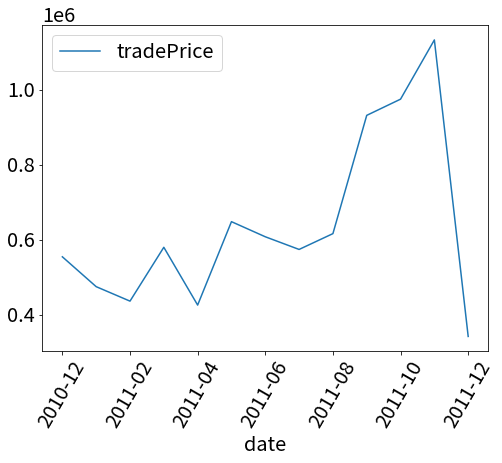

In [133]:
pdf = trade_df.toPandas()
pdf.plot(x='date', y='tradePrice')
plt.xticks(rotation=60)

### 日销量随时间的变化趋势

In [6]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [42]:
def format_date():
    tradeRDD = df.select("InvoiceDate", "Quantity", 'UnitPrice').rdd
    # 只要日期
    result1 = tradeRDD.map(
        lambda line: (line['InvoiceDate'].split(" ")[0], line['Quantity'], line['UnitPrice'])
    )
    # [[8, 11, 2011], Q, U] -> [2011-08, Q, U]
    result2 = result1 \
        .map(lambda l: (l[0].split('/'), l[1], l[2])) \
        .map(lambda l: [
            "-".join([l[0][-1], l[0][0], l[0][1]]),
             l[1], l[2]])
    return result2

formated_data = format_date()
trade = formated_data.map(lambda l: [l[0], l[1] * l[2]]).reduceByKey(lambda a, b: a+b).sortByKey()
trade.take(3)

[('2010-12-1', 46051.26000000007),
 ('2010-12-10', 32005.35000000008),
 ('2010-12-12', 17217.62000000005)]

In [38]:
from pyspark.sql.functions import to_date

In [43]:
schema = StructType([
    StructField("date", StringType(), False),
    StructField("tradePrice", DoubleType(), False),]
)
trade_df = spark.createDataFrame(trade, schema)
trade_df.show()

+----------+------------------+
|      date|        tradePrice|
+----------+------------------+
| 2010-12-1| 46051.26000000007|
|2010-12-10| 32005.35000000008|
|2010-12-12| 17217.62000000005|
|2010-12-13|27429.430000000066|
|2010-12-14|26913.410000000164|
|2010-12-15| 29310.79000000012|
|2010-12-16| 48011.52999999994|
|2010-12-17|18162.420000000035|
|2010-12-19| 7399.789999999991|
| 2010-12-2|  45775.4299999999|
|2010-12-20| 17574.58000000003|
|2010-12-21|15750.460000000005|
|2010-12-22| 4821.119999999998|
|2010-12-23| 5384.169999999993|
| 2010-12-3|22598.460000000086|
| 2010-12-5|31380.600000000162|
| 2010-12-6|30465.080000000165|
| 2010-12-7| 53125.99000000011|
| 2010-12-8|38048.680000000095|
| 2010-12-9| 37177.85000000004|
+----------+------------------+
only showing top 20 rows



In [44]:
# trade_df.select(to_date(trade_df['date']).alias('date'), ).show()
trade_df = trade_df.select(trade_df['date'].cast('date').alias('date'), 'tradePrice')
trade_df.show()

+----------+------------------+
|      date|        tradePrice|
+----------+------------------+
|2010-12-01| 46051.26000000007|
|2010-12-10| 32005.35000000008|
|2010-12-12| 17217.62000000005|
|2010-12-13|27429.430000000066|
|2010-12-14|26913.410000000164|
|2010-12-15| 29310.79000000012|
|2010-12-16| 48011.52999999994|
|2010-12-17|18162.420000000035|
|2010-12-19| 7399.789999999991|
|2010-12-02|  45775.4299999999|
|2010-12-20| 17574.58000000003|
|2010-12-21|15750.460000000005|
|2010-12-22| 4821.119999999998|
|2010-12-23| 5384.169999999993|
|2010-12-03|22598.460000000086|
|2010-12-05|31380.600000000162|
|2010-12-06|30465.080000000165|
|2010-12-07| 53125.99000000011|
|2010-12-08|38048.680000000095|
|2010-12-09| 37177.85000000004|
+----------+------------------+
only showing top 20 rows



In [47]:
trade_df = trade_df.sort(trade_df.date)

+----------+------------------+
|      date|        tradePrice|
+----------+------------------+
|2010-12-01| 46051.26000000007|
|2010-12-02|  45775.4299999999|
|2010-12-03|22598.460000000086|
|2010-12-05|31380.600000000162|
|2010-12-06|30465.080000000165|
|2010-12-07| 53125.99000000011|
|2010-12-08|38048.680000000095|
|2010-12-09| 37177.85000000004|
|2010-12-10| 32005.35000000008|
|2010-12-12| 17217.62000000005|
|2010-12-13|27429.430000000066|
|2010-12-14|26913.410000000164|
|2010-12-15| 29310.79000000012|
|2010-12-16| 48011.52999999994|
|2010-12-17|18162.420000000035|
|2010-12-19| 7399.789999999991|
|2010-12-20| 17574.58000000003|
|2010-12-21|15750.460000000005|
|2010-12-22| 4821.119999999998|
|2010-12-23| 5384.169999999993|
+----------+------------------+
only showing top 20 rows



(array([734138., 734197., 734258., 734319., 734381., 734442.]),
 <a list of 6 Text major ticklabel objects>)

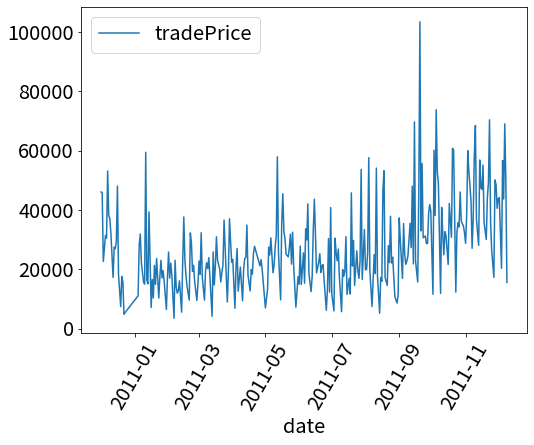

In [48]:
pdf = trade_df.toPandas()
pdf.plot(x='date', y='tradePrice')
plt.xticks(rotation=60)

### 各国的购买订单量和退货订单量的关系

InvoiceNo字段表示订单编号，退货订单的编号的首个字母为C，例如C540250。

In [15]:
returnDF = spark.sql("""
    SELECT 
        Country as Country1, COUNT(DISTINCT InvoiceNo) as return_sum
    FROM
        data
    WHERE
        InvoiceNo LIKE "C%"
    GROUP BY
        Country
""")
returnDF.show()

+------------------+----------+
|          Country1|return_sum|
+------------------+----------+
|            Sweden|        10|
|         Singapore|         3|
|           Germany|       146|
|            France|        69|
|            Greece|         1|
|European Community|         1|
|           Belgium|        21|
|           Finland|         7|
|             Malta|         5|
|             Italy|        17|
|              EIRE|        59|
|            Norway|         4|
|             Spain|        15|
|           Denmark|         3|
|            Israel|         1|
|   Channel Islands|         7|
|               USA|         2|
|            Cyprus|         4|
|      Saudi Arabia|         1|
|       Switzerland|        20|
+------------------+----------+
only showing top 20 rows



In [16]:
buyDF = spark.sql("""
    SELECT 
        Country as Country2, COUNT(DISTINCT InvoiceNo) as buy_sum
    FROM
        data
    WHERE
        InvoiceNo NOT LIKE "C%"
    GROUP BY
        Country
""")
buyDF.show()

+------------------+-------+
|          Country2|buy_sum|
+------------------+-------+
|            Sweden|     36|
|         Singapore|      7|
|           Germany|    457|
|               RSA|      1|
|            France|    389|
|            Greece|      5|
|European Community|      4|
|           Belgium|     98|
|           Finland|     41|
|             Malta|      5|
|       Unspecified|      8|
|             Italy|     38|
|              EIRE|    260|
|         Lithuania|      4|
|            Norway|     36|
|             Spain|     90|
|           Denmark|     18|
|           Iceland|      7|
|            Israel|      5|
|   Channel Islands|     26|
+------------------+-------+
only showing top 20 rows



In [20]:
relation = buyDF.join(returnDF, returnDF.Country1 == buyDF.Country2, 'leftouter')
relation.show()

+------------------+-------+------------------+----------+
|          Country2|buy_sum|          Country1|return_sum|
+------------------+-------+------------------+----------+
|            Sweden|     36|            Sweden|        10|
|         Singapore|      7|         Singapore|         3|
|           Germany|    457|           Germany|       146|
|               RSA|      1|              null|      null|
|            France|    389|            France|        69|
|            Greece|      5|            Greece|         1|
|European Community|      4|European Community|         1|
|           Belgium|     98|           Belgium|        21|
|           Finland|     41|           Finland|         7|
|             Malta|      5|             Malta|         5|
|       Unspecified|      8|              null|      null|
|             Italy|     38|             Italy|        17|
|              EIRE|    260|              EIRE|        59|
|         Lithuania|      4|              null|      nul

In [21]:
relation = relation.select(relation['Country2'].alias('Country'), 'buy_sum', "return_sum")
relation.show()

+------------------+-------+----------+
|           Country|buy_sum|return_sum|
+------------------+-------+----------+
|            Sweden|     36|        10|
|         Singapore|      7|         3|
|           Germany|    457|       146|
|               RSA|      1|      null|
|            France|    389|        69|
|            Greece|      5|         1|
|European Community|      4|         1|
|           Belgium|     98|        21|
|           Finland|     41|         7|
|             Malta|      5|         5|
|       Unspecified|      8|      null|
|             Italy|     38|        17|
|              EIRE|    260|        59|
|         Lithuania|      4|      null|
|            Norway|     36|         4|
|             Spain|     90|        15|
|           Denmark|     18|         3|
|           Iceland|      7|      null|
|            Israel|      5|         1|
|   Channel Islands|     26|         7|
+------------------+-------+----------+
only showing top 20 rows



In [29]:
relation_pdf = relation.toPandas()

In [31]:
relation_pdf.describe()

,buy_sum,return_sum
count,37.000000,28.00000
mean,500.972973,130.50000
std,2730.359658,603.87879
min,1.000000,1.00000
25%,5.000000,3.00000
50%,17.000000,6.50000
75%,51.000000,15.50000
max,16649.000000,3208.00000


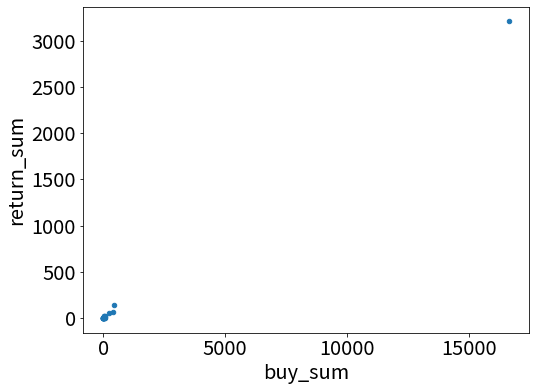

In [30]:
relation_pdf.plot.scatter(x='buy_sum', y='return_sum')

### 商品的平均单价与销量的关系

In [22]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [23]:
unit_price_sales = spark.sql("""
    SELECT
        StockCode, AVG(UnitPrice) as avg_price, SUM(Quantity) as sum_Quantity
    FROM
        data
    GROUP BY
        StockCode
""")
unit_price_sales.show()

+---------+------------------+------------+
|StockCode|         avg_price|sum_Quantity|
+---------+------------------+------------+
|    21889|1.2798076923076924|        5752|
|    22596|1.1659756097560976|        3265|
|    22728| 3.786159874608151|        5033|
|    21249|2.9145569620253178|         672|
|    21452| 2.939189189189191|         716|
|    21248|1.4499999999999997|         186|
|    21259|5.9240243902439005|        1116|
|    23318|2.4530523255814005|        3479|
|    20868| 0.567741935483871|         381|
|    22121| 6.061452991452988|         332|
|    22254|1.2453658536585366|         594|
|    21894|1.3145333333333333|         476|
|    21331|             12.75|          11|
|    90022|              3.75|           4|
|   90177A|              2.95|           0|
|    90143|               7.5|          17|
|   90210B| 2.016666666666667|          40|
|    23459|              12.5|          30|
|    84881|6.3500000000000005|          10|
|   90197B|              4.95|  

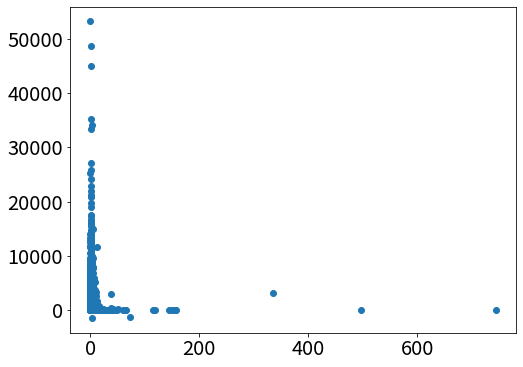

In [27]:
unit_price_sales_pdf = unit_price_sales.toPandas()
plt.scatter(unit_price_sales_pdf['avg_price'], unit_price_sales_pdf['sum_Quantity'])

plt.show()